# [CS-433] Practical Session on Generative Adversarial Networks
This is the practical session to the [CS-433 Machine Learning](https://edu.epfl.ch/coursebook/en/machine-learning-CS-433) Course at EPFL.

You can find the accompanying slides in the course materials, week **12**.

In this session, we will implement:
- **2-D Swiss Roll GAN.** a two-dimensional GAN - trained to generate samples from a Swiss-Roll manifold;
- Optional: **DCGAN on MNIST.** Implement a reduced model of [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (to generate $1\times 28 \times 28$ images), and train it on the MNIST dataset.

---
We recommend running this notebook in [Colab](https://colab.research.google.com/). Training will be faster if using a GPU. 
To run this colab on GPU, change the runtime type: `Runtime > Change runtime type`, and select GPU from the dropdown. We can check which GPU is available by running the following command:

On Colab, some cells contain 'hidden' code. Double-click those cells to see/close the source code.



In [1]:
!nvidia-smi

Tue Dec  1 08:27:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Note:** *if experimenting with hyper-parameters, ensure you re-intialize the networks, by re-running the cells they are defined in.*

# Swiss-Roll toy experiment

https://theloopywhisk.com/wp-content/uploads/2019/01/Chocolate-Swiss-Roll_730px_featured.jpg

<center>
<img src="https://theloopywhisk.com/wp-content/uploads/2019/01/Chocolate-Swiss-Roll_730px_featured.jpg" width="380" height="287" alt="Swiss Roll"><br>
<i>
Chocolate Swiss Roll CC BY Image by <a href="https://theloopywhisk.com/wp-content/uploads/2019/01/Chocolate-Swiss-Roll_730px_featured.jpg">The Loopy Whisk</a></i>
</center>



In [2]:
# @title Setup
# Learning rate of the generator:
g_lr = 1e-4  # @param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 5e-4  # @param {type:"number",  min:0.000001}
# batch size:
batch_size = 64  # @param {type:"integer",  min:1}
# dimension of tha latent vector
noise_dim = 100  # @param {type:"integer",  min:1}
# number of training iterations
total_iterations = 20000  # @param {type:"slider", min:1, max:50000, step:1}

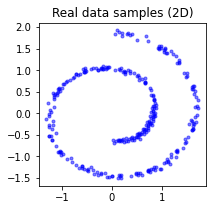

In [4]:
# @title Dataset
import torch
import sklearn.datasets  # we'll use it to create the Swiss Roll dataset
from matplotlib import pyplot as plt


def inf_data_gen(dataset=None, batch_size=None):
    """Python infinite iterator (called python-generator) of samples
    following certain distribution.

    Example Usage:
    data_generator = inf_data_gen(dataset='swissroll', batch_size=64)
    sample = next(data_generator)
    """
    if dataset.lower() == "swissroll":
        while True:
            data = sklearn.datasets.make_swiss_roll(n_samples=batch_size, noise=0.25)[0]
            data = data.astype("float32")[:, [0, 2]]
            data /= 7.5  # stdev plus a little
            yield data  # torch.from_numpy(data)
    else:
        raise NotImplementedError("Only supported dataset is SwissRoll")


# - Test -
data_generator = inf_data_gen(dataset="swissroll", batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker=".", alpha=0.5)
plt.title("Real data samples (2D)")
plt.show()

In [5]:
# @title Loss & GAN architecture: define MLPs for th Generator & the Discriminator
import torch.nn as nn

criterion = nn.BCELoss()  # Binary cross entropy


class GeneratorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=100):
        super(GeneratorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_out),
        )

    def forward(self, x):
        return self.net(x)


class DiscriminatorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(DiscriminatorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_gen_out = dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


g_model = GeneratorMLP(noise_dim=noise_dim)
d_model = DiscriminatorMLP()
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
# @title training functions
def train_generator(gen, disc, loss=None, batch_size=64, device=torch.device("cpu")):
    """Updates the params of disc['model'] (once).

    :param gen: dictionary with key 'model' [torch.nn.Sequential] and
                'optim' [torch.optim]
    :param disc: dictionary with key 'model' [torch.nn.Sequential]
    :param loss: [torch.nn.<loss>]
    :param batch_size: [int]
    :param device: torch.device('cuda') or torch.device('cpu')
    :return: None
    """
    loss = loss or nn.BCELoss()  # Binary cross entropy
    labels = torch.ones(batch_size, 1, device=device)
    noise = torch.randn(batch_size, gen["model"].noise_dim, device=device)

    gen["model"].zero_grad()
    loss(disc["model"](gen["model"](noise)), labels).backward()
    gen["optim"].step()  # update params of the generator
    return


def train_discriminator(
    gen,
    disc,
    data_sampler,
    n_steps=1,
    loss=None,
    batch_size=64,
    device=torch.device("cpu"),
):
    """Updates the params of disc['model'] n_steps times.

    :param gen: dictionary with key 'model' [torch.nn.Sequential]
    :param disc: dictionary with key 'model' [torch.nn.Sequential] and
                 'optim' [torch.optim]
    :param data_sampler: [python generator (https://wiki.python.org/moin/Generators)]
    :param n_steps: [int]
    :param loss: [torch.nn.<loss>]
    :param batch_size: [int]
    :param device: torch.device('cuda') or torch.device('cpu')
    :return: None
    """
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)
    loss = loss or nn.BCELoss()  # Binary cross entropy

    for _ in range(n_steps):
        disc["model"].zero_grad()
        #  1. Backprop - D on real: maximize log(D(x)) + log(1 - D(G(z)))
        real_samples = torch.tensor(next(data_sampler), device=device)
        loss(disc["model"](real_samples), real_labels).backward()

        #  2. Backprop - D on fake:
        noise = torch.randn(batch_size, gen["model"].noise_dim, device=device)
        loss(disc["model"](gen["model"](noise)), fake_labels).backward()

        #  3. Update the parameters  of the generator
        disc["optim"].step()
    return

In [9]:
# @title train & store fake samples throughout training

if torch.cuda.is_available():
    g_model = g_model.cuda()
    d_model = d_model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
g_optim = torch.optim.Adam(g_model.parameters(), lr=g_lr, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(d_model.parameters(), lr=d_lr, betas=(0.5, 0.999))

generator = {"model": g_model, "optim": g_optim}
discriminator = {"model": d_model, "optim": d_optim}

fixed_noise = torch.randn(300, noise_dim, device=device)
data_generator = inf_data_gen(dataset="swissroll", batch_size=batch_size)

plot_frequency = total_iterations // 100
fake_samples = []
for i in range(total_iterations):
    train_discriminator(
        generator,
        discriminator,
        data_sampler=data_generator,
        loss=criterion,
        batch_size=batch_size,
        device=device,
    )

    train_generator(
        generator, discriminator, loss=criterion, batch_size=batch_size, device=device
    )

    if i % plot_frequency == 0 or (i + 1) == total_iterations:
        fake_samples.append(generator["model"](fixed_noise).cpu().detach().numpy())

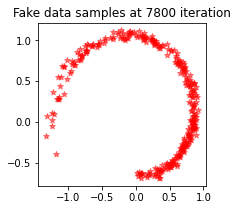

In [16]:
# @title Plot fake samples: select the iteration (0 and 100 are at begining and end of training, resp.)
iteration_plot_generator_samples = 39  # @param {type:"slider", min:0, max:100, step:1}

fake_sample = fake_samples[iteration_plot_generator_samples]
plt.figure(figsize=(3, 3))
plt.scatter(fake_sample[:, 0], fake_sample[:, 1], c="red", marker="*", alpha=0.5)
plt.title(
    f"Fake data samples at {iteration_plot_generator_samples*plot_frequency} iteration"
)
plt.show()

# Optional: DCGAN on MNIST

Examples of DCGAN generated images, trained on MNIST (the animation is over training steps):

<img src="https://docs.google.com/uc?export=download&id=1UNCENHn736j6R1YUnRSbGfDGdfKAt7DJ" width="400px"/>

In [17]:
# @title DCGAN architectures
import numpy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vision_utils
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt


_NOISE_DIM = 128
_H_FILTERS = 64


class DiscriminatorCNN28(nn.Module):
    def __init__(
        self,
        img_channels=1,
        h_filters=_H_FILTERS,
        spectral_norm=False,
        img_size=None,
        n_outputs=1,
    ):
        """Defines the architecture of the Discriminator.

        :param img_channels: [int] e.g. 1 and 3 for greyscale and RGB, resp.
        :param h_filters: [int] depth of the convolution kernels
        :param spectral_norm: [bool] True activates Spectral Norm
        :param img_size: [int]
        :param n_outputs: [int]
        """
        if any(
            not isinstance(_arg, int) for _arg in [img_channels, h_filters, n_outputs]
        ):
            raise TypeError("Unsupported operand type. Expected integer.")
        if not isinstance(spectral_norm, bool):
            raise TypeError(
                f"Unsupported operand type: {type(spectral_norm)}." " Expected bool."
            )
        if min([img_channels, h_filters, n_outputs]) <= 0:
            raise ValueError(
                "Expected nonzero positive input arguments for: the "
                "number of output channels, the depth of the convolution "
                "kernels, as well as ."
            )
        super(DiscriminatorCNN28, self).__init__()
        _apply_sn = lambda x: nn.utils.spectral_norm(x) if spectral_norm else x
        self.img_channels = img_channels
        self.img_size = img_size
        self.n_outputs = n_outputs
        self.main = nn.Sequential(
            _apply_sn(nn.Conv2d(img_channels, h_filters, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            _apply_sn(nn.Conv2d(h_filters, h_filters * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(h_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),
            _apply_sn(nn.Conv2d(h_filters * 2, h_filters * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(h_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),
            _apply_sn(nn.Conv2d(h_filters * 4, self.n_outputs, 3, 1, 0, bias=False)),
        )

    def forward(self, x):
        if self.img_channels is not None and self.img_size is not None:
            if (
                numpy.prod(list(x.size())) % (self.img_size**2 * self.img_channels)
                != 0
            ):
                raise ValueError(
                    f"Size mismatch. Input size: {numpy.prod(list(x.size()))}. "
                    f"Expected input divisible by: {self.noise_dim}"
                )
            x = x.view(-1, self.img_channels, self.img_size, self.img_size)
        x = self.main(x)
        return x.view(-1, self.n_outputs)

    def load(self, model):
        self.load_state_dict(model.state_dict())


class GeneratorCNN28(nn.Module):
    def __init__(
        self, img_channels=1, noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=False
    ):
        """Defines the architecture of the Generator.

        :param img_channels: [int] e.g. 1 and 3 for greyscale and RGB, resp.
        :param noise_dim: [int] the dimension of the noise vector
        :param h_filters: [int] the depth of the convolution kernels
        :param out_tanh: [bool] if True use Tanh as last non-linearity, Sigmoid otherwise
        """
        if any(
            not isinstance(_arg, int) for _arg in [img_channels, noise_dim, h_filters]
        ):
            raise TypeError("Unsupported operand type. Expected integer.")
        if min([img_channels, noise_dim, h_filters]) <= 0:
            raise ValueError(
                "Expected strictly positive input arguments for the "
                "number of output channels, the dimension of the noise "
                "vector, as well as the depth of the convolution kernels."
            )
        super(GeneratorCNN28, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, h_filters * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(_H_FILTERS * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h_filters * 8, h_filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(_H_FILTERS * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h_filters * 4, h_filters * 2, 4, 2, 0, bias=False),
            nn.BatchNorm2d(_H_FILTERS * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h_filters * 2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh() if out_tanh else nn.Sigmoid(),
        )

    def forward(self, x):
        if numpy.prod(list(x.size())) % self.noise_dim != 0:
            raise ValueError(
                f"Size mismatch. Input size: {numpy.prod(list(x.size()))}. "
                f"Expected input divisible by: {self.noise_dim}"
            )
        x = x.view(-1, self.noise_dim, 1, 1)
        x = self.main(x)
        return x

    def load(self, model):
        self.load_state_dict(model.state_dict())

In [19]:
# @title Dataloader
def load_mnist(data_dir="datasets"):
    """Load the MNIST dataset, or download it if not found.

    :param data_dir: [string]
    :return: [torch.utils.data.Dataset]
    """
    trans = _transforms.ToTensor()
    _data = _datasets.MNIST(data_dir, train=True, download=True, transform=trans)
    return _data


def get_sampler(dataset, batch_size, shuffle=True, num_workers=1, drop_last=True):
    """A wrapper of PyTorch DataLoader class which allows to loop over the dataset
    infinitely. Returns a function we will use to sample batches from our dataset.

    :param dataset: [torch.utils.data.Dataset]
    :param batch_size:  [int]
    :param shuffle: [bool]
    :param num_workers: [int]
    :param drop_last: [bool]
    :return:
    """
    data_loader = DataLoader(
        dataset,
        batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        drop_last=drop_last,
    )
    dataloader_iterator = iter(data_loader)

    def sampler():
        nonlocal dataloader_iterator
        try:
            data = next(dataloader_iterator)  # if there is a next batch we use it
        except StopIteration:
            dataloader_iterator = iter(data_loader)  # else we loop again the dataset
            data = next(dataloader_iterator)
        return data

    return sampler

In [21]:
# @title Training Functions


def get_disciminator_loss(D, x_real, x_gen, lbl_real, lbl_fake):
    """Helper function, returns loss of Discriminator. The Discriminator classifies
    samples as real or fake, hence uses binary cross entropy.

    :param D: [torch.nn] discriminator
    :param x_real: [torch.tensor] real data samples, size n_channels x im_size x im_size
    :param x_gen: [torch.tensor] fake data samples, size n_channels x im_size x im_size
    :param lbl_real: [torch.tensor] label for real samples
    :param lbl_fake: [torch.tensor] label for fake samples
    :return: total loss of the discriminator
    """
    D_x = D(x_real)  # discriminator probabilities for the real samples
    D_G_z = D(x_gen)  # discriminator probabilities for the fake samples
    lossD_real = torch.binary_cross_entropy_with_logits(D_x, lbl_real).mean()
    lossD_fake = torch.binary_cross_entropy_with_logits(D_G_z, lbl_fake).mean()
    lossD = lossD_real + lossD_fake
    return lossD


def get_generator_loss(G, D, z, lbl_real):
    """Helper function, returns loss of Generator. The Generator aims at making
    the discriminator output the real label, given fake images.

    :param G: [torch.nn] generator
    :param D: [torch.nn] discriminator
    :param z: [torch.tensor] latent/noise vector
    :param lbl_real: [torch.tensor] label for real samples
    :return: loss of the generator
    """
    D_G_z = D(
        G(z)
    )  # Get the probability of the fake images (created from G with the noise z)
    lossG = torch.binary_cross_entropy_with_logits(
        D_G_z, lbl_real
    ).mean()  # Fake samples classified as real
    return lossG


def train(
    G,
    D,
    dataset,
    iterations,
    batch_size=32,
    lrD=0.01,
    lrG=0.01,
    beta1=0.99,
    plot_every=100,
    n_workers=5,
    device=torch.device("cpu"),
):
    """Training function.

    :param G: [torch.nn] generator
    :param D: [torch.nn] discriminator
    :param dataset: [torch.utils.data.Dataset]
    :param iterations: [int] number of training steps
    :param batch_size:  [int]
    :param lrD: [float] learning rate for the discriminator
    :param lrG: [float] learning rate for the generator
    :param beta1: [float] hyperparameter for the Adam optimizer
    :param plot_every: [int] plotting frequency w.r.t. iterations
    :param n_workers: [int] used for the dataloader to load batches in parallel
    :param device: torch.device('cpu') or torch.device('cuda')
    :return:
    """

    sampler = get_sampler(
        dataset, batch_size, shuffle=True, num_workers=n_workers, drop_last=True
    )  # the sampler is used to iterate over the dataset of real images

    # Optimizers
    optimizerD = torch.optim.Adam(D.parameters(), lr=lrD, betas=(beta1, 0.999))
    optimizerG = torch.optim.Adam(G.parameters(), lr=lrG, betas=(beta1, 0.999))

    # LBLs
    lbl_real = torch.ones(
        batch_size, 1, device=device
    )  # we define 1 as being the output of D when he thinks the image is real
    lbl_fake = torch.zeros(
        batch_size, 1, device=device
    )  # we define 0 as being the output of D when he thinks the image is fake

    fixed_noise = torch.randn(
        100, G.noise_dim, device=device
    )  # we use this noise to generate the images to print

    G.to(device)  # move the generator to the proper device (e.g. GPU)
    D.to(device)  # move the discriminator to the proper device (e.g. GPU)

    for i in range(iterations):
        # STEP 1: D optimization step using G
        x_real, _ = sampler()  # we get some real images
        x_real = x_real.to(device)  # send them to the proper device (e.g. GPU)
        z = torch.randn(batch_size, G.noise_dim, device=device)  # we sample some noise
        with torch.no_grad():
            x_gen = G(z)  # We generate random images from the noise
        optimizerD.zero_grad()  # Always zero your gradient before doing backward !
        lossD = get_disciminator_loss(D, x_real, x_gen, lbl_real, lbl_fake)
        lossD.backward()  # compute gradient for the discriminator
        optimizerD.step()

        # STEP 4: G optimization step using D
        z = torch.randn(
            batch_size, G.noise_dim, device=device
        )  # we get some random noise
        optimizerG.zero_grad()  # Always zero your gradient before doing backward !
        lossG = get_generator_loss(G, D, z, lbl_real)
        lossG.backward()
        optimizerG.step()  # Important remark here: we backpropagated to both the discriminator and the
        # generator with `lossG.backward()`, but optimizerG is only updating the weights
        # of the generator. Updating the weights of the discriminator would be cheating.

        # plotting things
        if i % plot_every == 0 or i == iterations:
            with torch.no_grad():
                probas = torch.sigmoid(D(G(fixed_noise)))
                mean_proba = probas.mean().cpu().item()
                std_proba = probas.std().cpu().item()
                samples = G(fixed_noise).cpu()
                fig = plt.figure(figsize=(12, 5), dpi=100)
                samples = samples.view(100, 1, 28, 28)
                grid_img = vision_utils.make_grid(
                    samples, nrow=10, normalize=True, padding=0
                )
                plt.imshow(grid_img.permute(1, 2, 0), interpolation="nearest")
                print(
                    f"Iter {i}: Mean proba from D(G(z)): {mean_proba:.4f} +/- {std_proba:.4f}"
                )
                plt.show()

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw




Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Iter 0: Mean proba from D(G(z)): 0.9800 +/- 0.0073



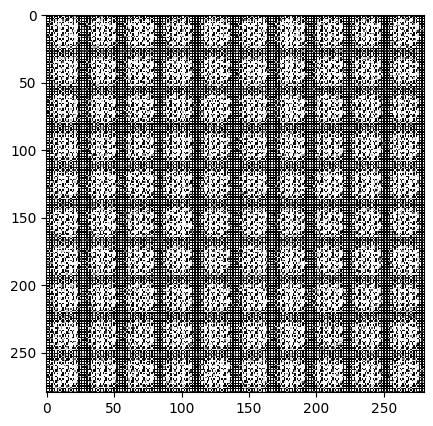

Iter 1000: Mean proba from D(G(z)): 0.3482 +/- 0.1856


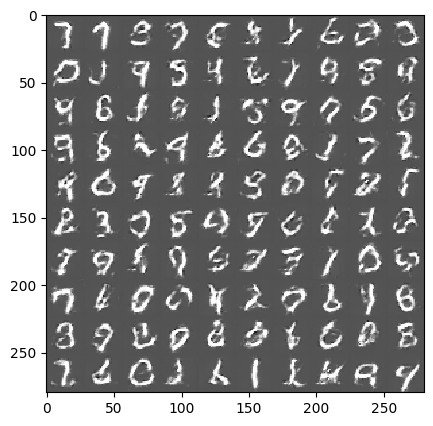

Iter 2000: Mean proba from D(G(z)): 0.2727 +/- 0.2129


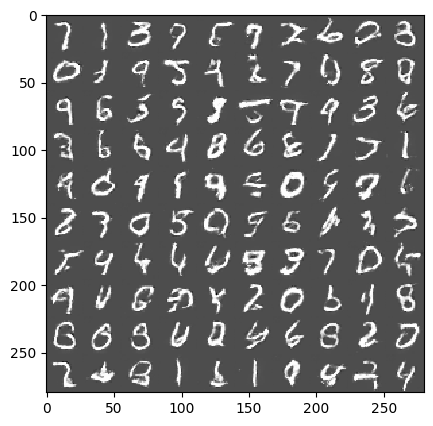

Iter 3000: Mean proba from D(G(z)): 0.4325 +/- 0.2225


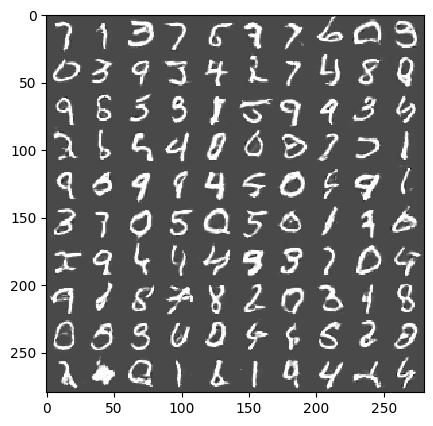

Iter 4000: Mean proba from D(G(z)): 0.0925 +/- 0.1102


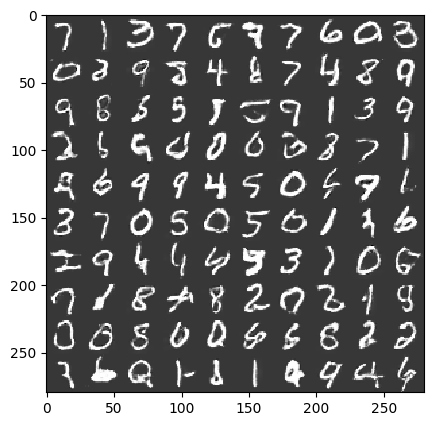

Iter 5000: Mean proba from D(G(z)): 0.3671 +/- 0.2246


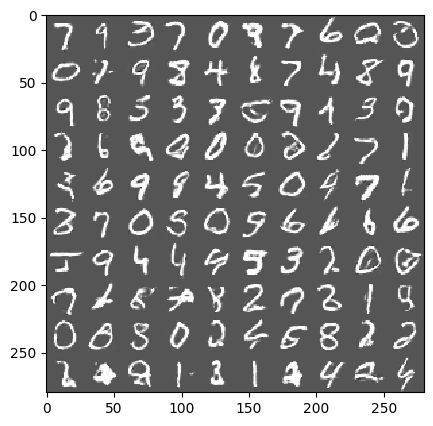

Iter 6000: Mean proba from D(G(z)): 0.1173 +/- 0.1291


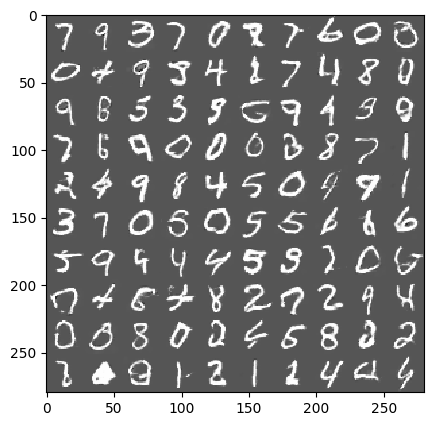

Iter 7000: Mean proba from D(G(z)): 0.0944 +/- 0.0940


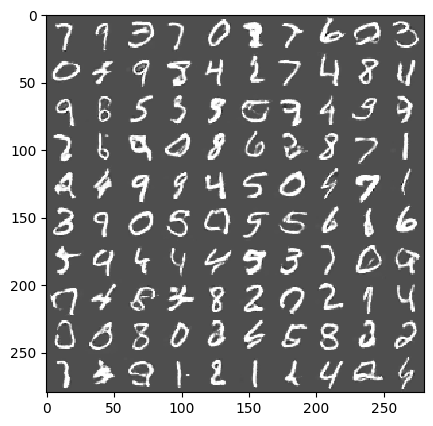

Iter 8000: Mean proba from D(G(z)): 0.1609 +/- 0.1334


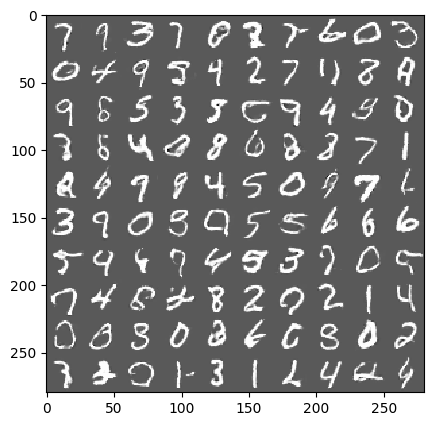

Iter 9000: Mean proba from D(G(z)): 0.0165 +/- 0.0335


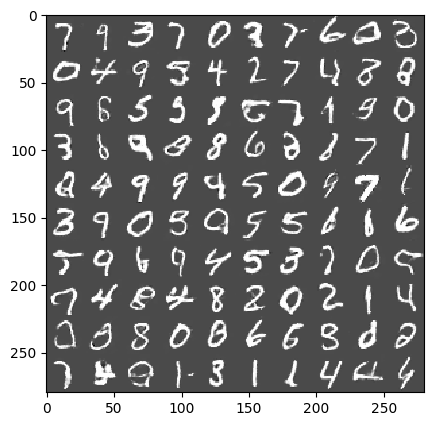

Iter 10000: Mean proba from D(G(z)): 0.2067 +/- 0.1850


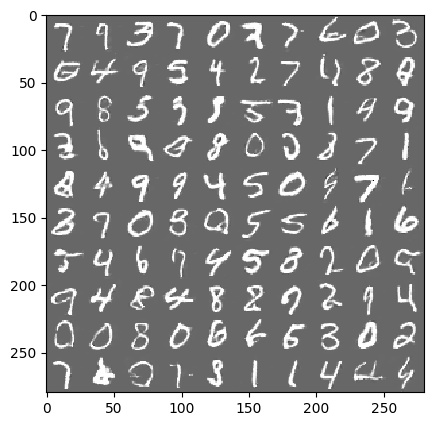

Iter 11000: Mean proba from D(G(z)): 0.0720 +/- 0.0708


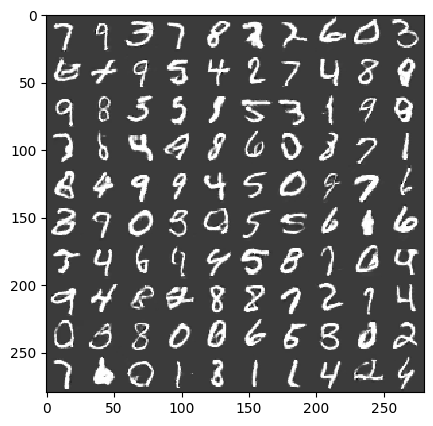

Iter 12000: Mean proba from D(G(z)): 0.1000 +/- 0.1473


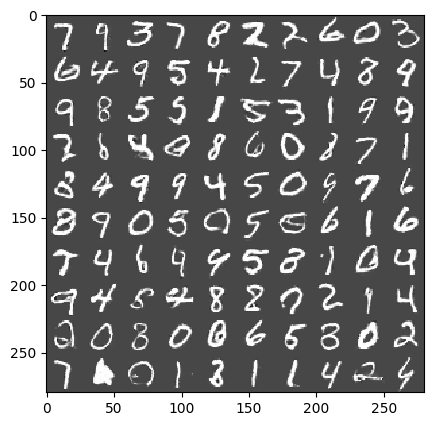

Iter 13000: Mean proba from D(G(z)): 0.3870 +/- 0.2309


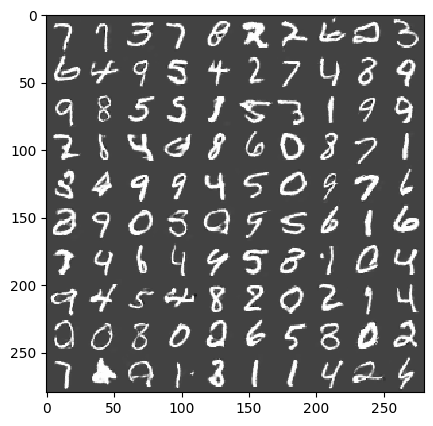

Iter 14000: Mean proba from D(G(z)): 0.1972 +/- 0.1793


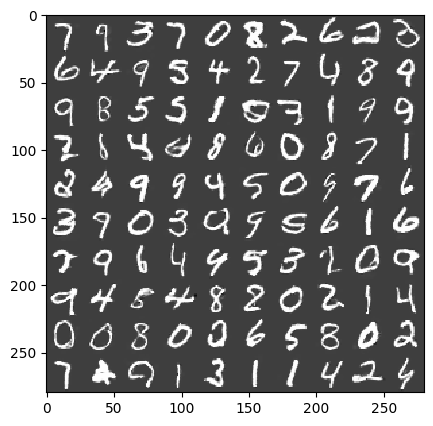

Iter 15000: Mean proba from D(G(z)): 0.5319 +/- 0.2715


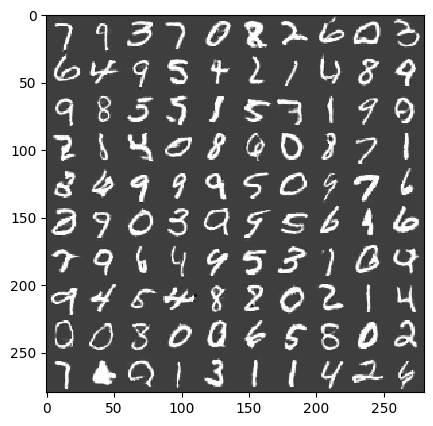

Iter 16000: Mean proba from D(G(z)): 0.1247 +/- 0.1352


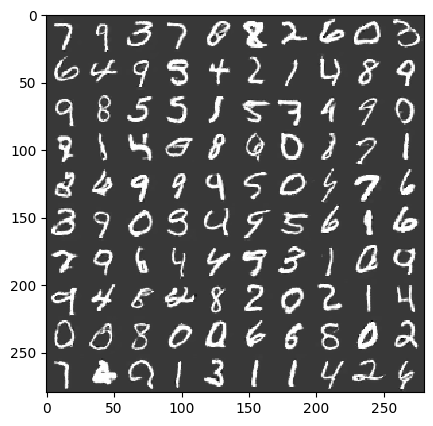

Iter 17000: Mean proba from D(G(z)): 0.3190 +/- 0.2252


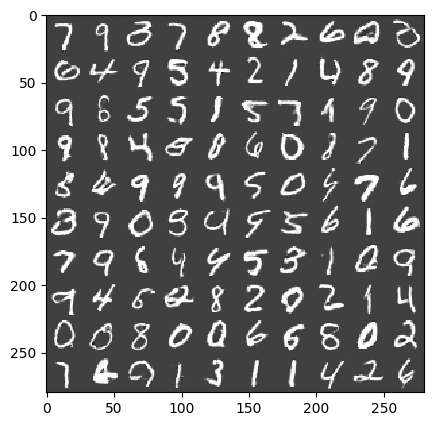

Iter 18000: Mean proba from D(G(z)): 0.0950 +/- 0.1146


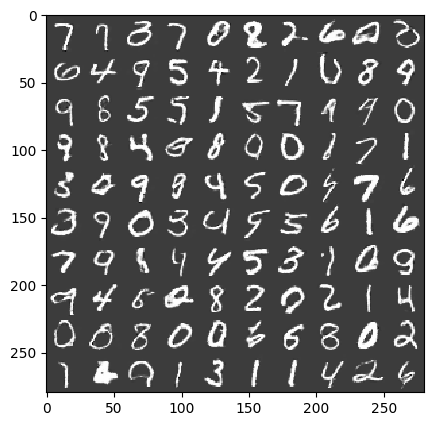

Iter 19000: Mean proba from D(G(z)): 0.4524 +/- 0.2887


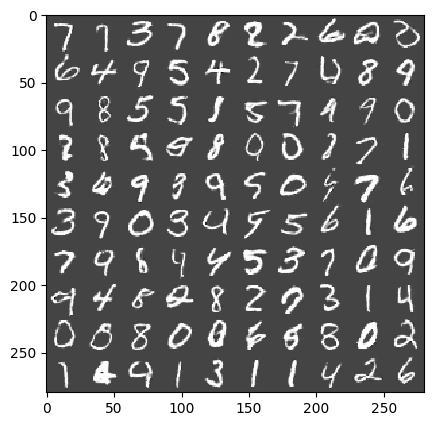

Iter 20000: Mean proba from D(G(z)): 0.0056 +/- 0.0162


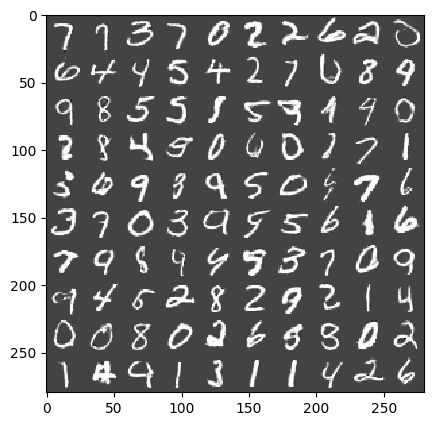

Iter 21000: Mean proba from D(G(z)): 0.1325 +/- 0.1539


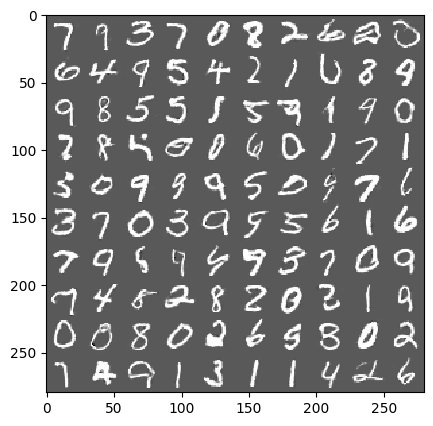

Iter 22000: Mean proba from D(G(z)): 0.0637 +/- 0.1300


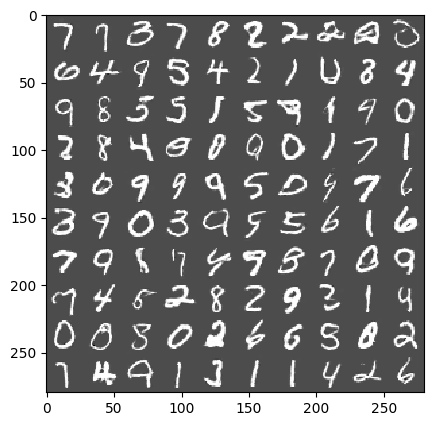

Iter 23000: Mean proba from D(G(z)): 0.0437 +/- 0.0865


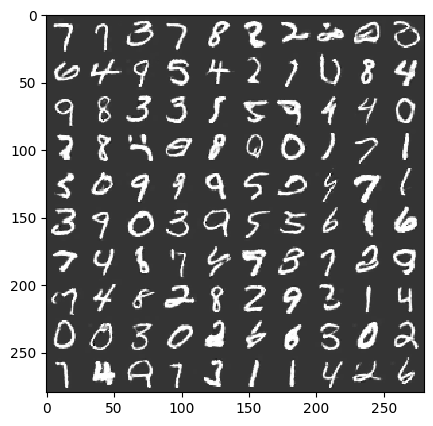

Iter 24000: Mean proba from D(G(z)): 0.0421 +/- 0.0826


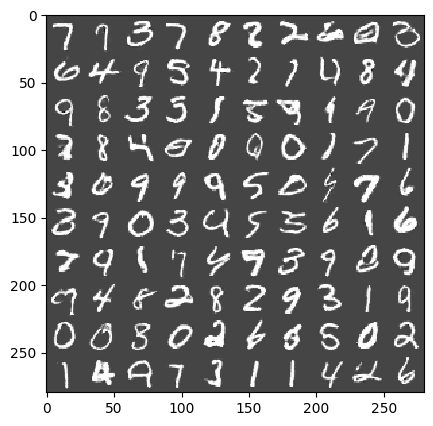

Iter 25000: Mean proba from D(G(z)): 0.2304 +/- 0.2458


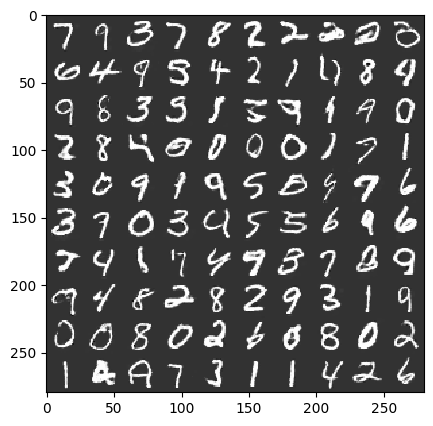

Iter 26000: Mean proba from D(G(z)): 0.0820 +/- 0.1169


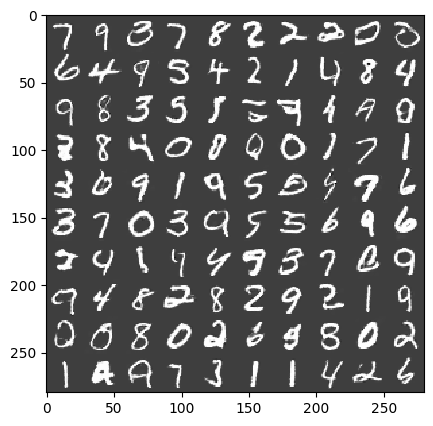

Iter 27000: Mean proba from D(G(z)): 0.0284 +/- 0.0762


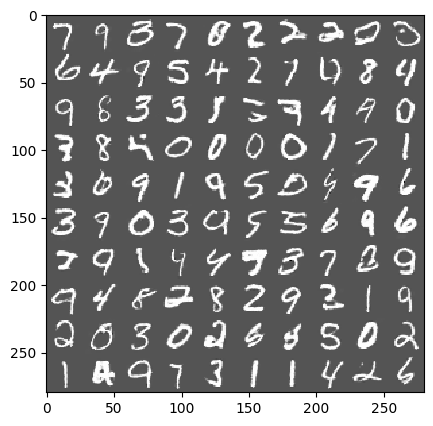

Iter 28000: Mean proba from D(G(z)): 0.0264 +/- 0.0402


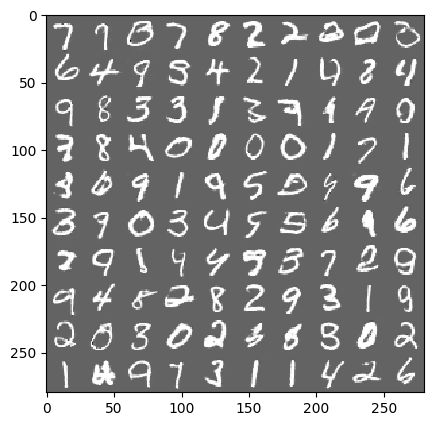

Iter 29000: Mean proba from D(G(z)): 0.1913 +/- 0.2167


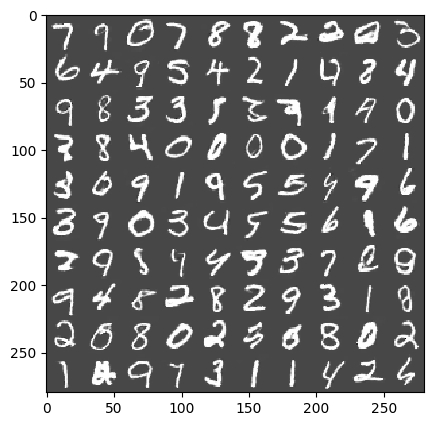

Iter 30000: Mean proba from D(G(z)): 0.6095 +/- 0.2658


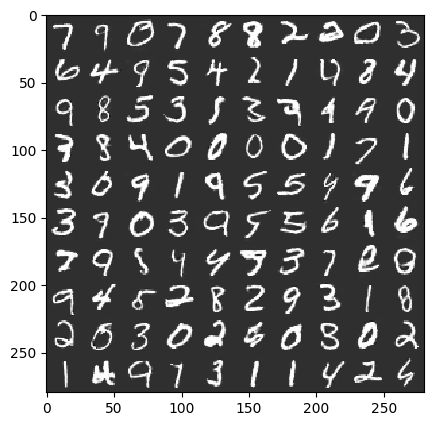

In [ ]:
# @title Train DCGAN

# Learning rate of the generator:
g_lr = 1e-3  # @param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 1e-3  # @param {type:"number",  min:0.000001}
# batch size:
batch_size = 50  # @param {type:"integer",  min:1}
# number of training iterations
total_iterations = 50000  # @param {type:"slider", min:1, max:150000, step:1}


dataset = load_mnist(data_dir="datasets")  # load the MNIST dataset

G = GeneratorCNN28(noise_dim=_NOISE_DIM, out_tanh=True)
D = DiscriminatorCNN28(spectral_norm=False, img_size=28)

train(
    G,
    D,
    dataset,
    iterations=total_iterations,
    batch_size=batch_size,  # Hyper-parameter: batch size
    lrD=d_lr,  # Hyper-parameter: learning rate of the discriminator
    lrG=g_lr,  # Hyper-parameter: learning rate of the generator
    beta1=0.05,  # Hyper-parameter: for Adam (smaller values empirically shown better)
    plot_every=1000,
    n_workers=5,
    device="cuda",
)